# Week4. Homework.

## Author George Chizhmak (10.10.2023).

Dataset
In this homework, we will use the Car price dataset. Download it from here [https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv].

We'll keep working with the MSRP variable, and we'll transform it to a classification task.

## Features
For the rest of the homework, you'll need to use only these columns:

Make,
Model,
Year,
Engine HP,
Engine Cylinders,
Transmission Type,
Vehicle Style,
highway MPG,
city mpg,
MSRP

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("./data.csv")

In [3]:
data.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [4]:
data = data[['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']]

## Data preparation

Select only the features from above and transform their names using the next line:
data.columns = data.columns.str.replace(' ', '_').str.lower()
Fill in the missing values of the selected features with 0.
Rename MSRP variable to price.

In [5]:
data.columns = data.columns.str.replace(' ', '_').str.lower()

In [6]:
data.fillna(0, inplace=True)

In [7]:
data.rename(columns={"msrp": "price"}, inplace=True)

## Make price binary

Now we need to turn the price variable from numeric into a binary format.
Let's create a variable above_average which is 1 if the price is above its mean value and 0 otherwise.

In [8]:
data_with_price = data.copy()

mean_price = data['price'].mean()
data['above_average'] = data['price'].apply(lambda x: 1 if x > mean_price else 0)

del data['price']

## Split the data

- Split your data in train/val/test sets with 60%/20%/20% distribution.
- Use Scikit-Learn for that (the train_test_split function) and set the seed to 1.
- Make sure that the target value (above_average) is not in your dataframe.

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
df_train_full, df_test = train_test_split(data, test_size=0.2, random_state=1)

In [11]:
df_train, df_val = train_test_split(df_train_full, test_size=0.2, random_state=1)

In [12]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values

In [13]:
del df_train['above_average']
del df_val['above_average']

## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score and compute AUC with the above_average variable
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

engine_hp
engine_cylinders
highway_mpg
city_mpg

In [20]:
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer

numerical_variables = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [21]:
best_variable = None
best_auc = 0

for variable in numerical_variables:
    # Calculate the ROC AUC
    auc = metrics.roc_auc_score(y_train, df_train[variable])

    # Check if AUC is less than 0.5 and invert the variable
    if auc < 0.5:
        auc = metrics.roc_auc_score(y_train, -df_train[variable])

    # Update the best variable if needed
    if auc > best_auc:
        best_auc = auc
        best_variable = variable

print("The numerical variable with the highest AUC is:", best_variable)
print("AUC for the best variable:", best_auc)

The numerical variable with the highest AUC is: engine_hp
AUC for the best variable: 0.9162324220917971


## Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [22]:
from sklearn.feature_extraction import DictVectorizer

In [23]:
train_dict = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [27]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [30]:
print(round(metrics.roc_auc_score(y_val, model.predict(X_val)), 3))

0.918


## Question 3: Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

- 0.28
- 0.48
- 0.68
- 0.88

In [31]:
# Create an array of thresholds from 0.0 to 1.0 with a step of 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

precision_scores = []
recall_scores = []

for threshold in thresholds:
    # Make predictions based on the threshold
    y_pred = (model.predict_proba(X_val)[:, 1] >= threshold).astype(int)
    
    # Calculate precision and recall
    precision = metrics.precision_score(y_val, y_pred)
    recall = metrics.recall_score(y_val, y_pred)
    
    precision_scores.append(precision)
    recall_scores.append(recall)

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
import matplotlib.pyplot as plt

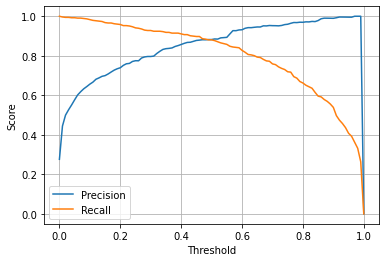

In [34]:
# Plot precision and recall curves
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both.


Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72

In [35]:
f1_scores = []

for threshold in thresholds:
    # Make predictions based on the threshold
    y_pred = (model.predict_proba(X_val)[:, 1] >= threshold).astype(int)
    
    # Calculate the F1 score
    f1 = metrics.f1_score(y_val, y_pred)
    
    f1_scores.append(f1)

# Find the threshold where F1 is maximal
max_f1 = max(f1_scores)
max_f1_threshold = thresholds[f1_scores.index(max_f1)]

print("The threshold at which F1 is maximal:", max_f1_threshold)

The threshold at which F1 is maximal: 0.46


## Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

In [37]:
from sklearn.model_selection import KFold

In [38]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

In [41]:
auc_scores = []

# Iterate over different folds
for train_idx, val_idx in kf.split(df_train_full):
    train_data, val_data = df_train_full.iloc[train_idx], df_train_full.iloc[val_idx]
    
    # Split the data into train and validation
    X_train, y_train = train_data.drop('above_average', axis=1), train_data['above_average']
    X_val, y_val = val_data.drop('above_average', axis=1), val_data['above_average']
    
    val_dict = X_val.to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    train_dict = X_train.to_dict(orient='records')
    X_train = dv.transform(train_dict)
    
    # Train the model on the training data
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Make predictions on the validation data
    y_pred = model.predict_proba(X_val)[:, 1]
    
    # Calculate the AUC score
    auc = metrics.roc_auc_score(y_val, y_pred)
    
    auc_scores.append(auc)

# Calculate the standard deviation of the AUC scores
std_deviation = np.std(auc_scores)

print("The standard deviation of the AUC scores across different folds is:", std_deviation)

The standard deviation of the AUC scores across different folds is: 0.0015432304849839476


## Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.01, 0.1, 0.5, 10]
Initialize KFold with the same parameters as previously
Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [42]:
C_values = [0.01, 0.1, 0.5, 10]
kf = KFold(n_splits=5, shuffle=True, random_state=1)
results = []

In [43]:
for C in C_values:
    auc_scores = []
    
    # Iterate over different folds
    for train_idx, val_idx in kf.split(df_train_full):
        train_data, val_data = df_train_full.iloc[train_idx], df_train_full.iloc[val_idx]

        # Split the data into train and validation
        X_train, y_train = train_data.drop('above_average', axis=1), train_data['above_average']
        X_val, y_val = val_data.drop('above_average', axis=1), val_data['above_average']
        
        val_dict = X_val.to_dict(orient='records')
        X_val = dv.transform(val_dict)

        train_dict = X_train.to_dict(orient='records')
        X_train = dv.transform(train_dict)

        # Train the model on the training data
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        # Make predictions on the validation data
        y_pred = model.predict_proba(X_val)[:, 1]

        # Calculate the AUC score
        auc = metrics.roc_auc_score(y_val, y_pred)

        auc_scores.append(auc)
    # for folds
    
    # Calculate the mean and standard deviation of AUC scores for this C
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    
    results.append((C, mean_auc, std_auc))
# for C

In [44]:
# Sort the results by mean score, standard deviation, and C in that order
results.sort(key=lambda x: (x[1], x[2], -x[0]))

# Select the best C based on the criteria
best_C = results[-1][0]
best_mean_score = round(results[-1][1], 3)

print("The C value that leads to the best mean score is:", best_C)
print("The mean score for the best C is:", best_mean_score)

The C value that leads to the best mean score is: 10
The mean score for the best C is: 0.983
